# Code

#### Code - get genotypes

In [8]:
import pandas as pd
import numpy as np
import allel

def vcf_to_siaya_glm_data(vcf_path, df_samples, max_missing_filter=0.20, min_maf_filter=0.02 ,split_multiallelic=True, convert_genotypes=True):
    # Read VCF and create a dictionary
    vcf_df = vcf_to_siaya_df(vcf_path, df_samples, max_missing_filter=max_missing_filter, min_maf_filter=min_maf_filter)
    samples = vcf_df.columns[6:]

    if split_multiallelic:
        vcf_df = split_rows_with_multiple_alleles(vcf_df, samples)

    # Convert genotypes to 0/1/2
    if convert_genotypes:
        vcf_df = convert_genotype_to_alt_allele_count(vcf_df, samples)

    vcf_df = vcf_df.assign(snp_id=lambda x: "snp_" + x.CHROM + ":" + x.POS.astype(str) + "_" + x.ALT)
    vcf_df = vcf_df.set_index('snp_id')
    vcf_df = vcf_df.drop(columns=['CHROM', 'POS', 'FILTER_PASS', 'REF', 'ALT', 'ANN']).T
    vcf_df = pd.concat([df_samples.set_index('sample_id').query('location == "Siaya"'), vcf_df], axis=1)
    
    return vcf_df
    

def vcf_to_siaya_df(vcf_path, df_samples, max_missing_filter=0.20, min_maf_filter=0.02, query=None):
    # Read VCF file
    vcf_dict = allel.read_vcf(vcf_path, fields='*')
    samples = vcf_dict['samples']
    contig = vcf_dict['variants/CHROM'] 
    pos = vcf_dict['variants/POS']
    filter_pass = vcf_dict['variants/FILTER_PASS']
    ref = vcf_dict['variants/REF']
    alt = [','.join([a for a in row if a != '']) for row in vcf_dict['variants/ALT']]
    alt = np.array(alt, dtype=object)  # or dtype=str if you want, but object is safest
    ann = vcf_dict['variants/ANN']
    geno = allel.GenotypeArray(vcf_dict['calldata/GT'])
    
    print(f"Initial number of samples: {len(samples)}")
    print(f"Initial number of SNPs: {geno.shape[0]}")
    
    # filter to Siaya data
    siaya_mask = df_samples.eval("sample_id.str.contains('Siaya')", engine='python')
    sample_mask = np.isin(samples, df_samples[siaya_mask].sample_id)

    geno = geno.compress(sample_mask, axis=1)
    samples = samples[sample_mask]

    if query is not None:
        mask = df_samples.eval(query, engine='python')
        geno = geno.compress(mask, axis=1)
        samples = samples[mask]
    
    print(f"Final number of samples: {len(samples)}")
        
    # Calculate allele counts and apply filters
    ac = geno.count_alleles(max_allele=3)
    seg_mask = ac.is_segregating()
    miss_mask = (geno.is_missing().sum(axis=1) <= int(geno.shape[1]*max_missing_filter))
    maf_mask = ac.to_frequencies()[:, 1:].sum(axis=1) > min_maf_filter
    
    print(f"invariant SNPs removed: {np.sum(~seg_mask)}")
    print(f"SNPs removed due to high missingness (>{max_missing_filter*100}%): {np.sum(~miss_mask)}")
    print(f"SNPs removed due to low MAF (<{min_maf_filter}): {np.sum(~maf_mask)}")
    
    # Apply all filters
    mask = np.logical_and(seg_mask, np.logical_and(miss_mask, maf_mask))
    
    # Compress data based on mask
    geno = geno.compress(mask, axis=0)
    contig = contig[mask]
    pos = pos[mask]
    filter_pass = filter_pass[mask]
    ref = ref[mask]
    alt = alt[mask]
    ann = ann[mask]
    
    print(f"Final number of SNPs after all filters: {geno.shape[0]}")
    
    # Create DataFrame versions of VCF and genotypes
    vcf_df = pd.DataFrame({'CHROM': contig, 'POS': pos, 'FILTER_PASS': filter_pass, 'REF': ref, 'ALT': alt, 'ANN': ann})
    geno_df = pd.DataFrame(geno.to_gt().astype(str), columns=samples)
    
    # Combine VCF and genotype DataFrames
    vcf = pd.concat([vcf_df, geno_df], axis=1)
    
    print(f"Final DataFrame shape: {vcf.shape}")
    
    return vcf

def split_rows_with_multiple_alleles(df, samples):
    # Create an empty list to store the new rows
    new_rows = []
    # Iterate through each row
    for index, row in df.iterrows():
        alt_alleles = row['ALT'].split(',')
        # Check if there are multiple alleles in the ALT field
        if len(alt_alleles) > 1:
            for allele_num, allele in enumerate(alt_alleles):
                # Create a new row for each allele
                new_row = row.copy()
                new_row['ALT'] = allele
                # Update genotype fields
                for col in samples:
                    genotype = row[col]
                    # Split the genotype and process it
                    if genotype != './.':
                        gt_alleles = genotype.split('/')
                        new_gt = ['0' if (int(gt) != allele_num + 1 and gt != '0') else gt for gt in gt_alleles]
                        new_row[col] = '/'.join(new_gt)
                new_rows.append(new_row)
        else:
            new_rows.append(row)
    
    new_df = pd.DataFrame(new_rows).reset_index(drop=True)
    return new_df


def convert_genotype_to_alt_allele_count(df, samples):
    nalt_df = df.copy()
    # Iterate through each row
    for index, row in df.iterrows():
        # Update genotype fields
        for col in samples:
                genotype = row[col]
                if genotype != './.':
                    # Split the genotype and count non-zero alleles
                    alleles = genotype.split('/')
                    alt_allele_count = sum([1 for allele in alleles if allele != '0'])
                    nalt_df.at[index, col] = alt_allele_count
                else:
                    nalt_df.at[index, col] = np.nan

    return nalt_df

#### Code -  run GLM and process results

In [ ]:
def calculate_pseudo_r2(results):
    """
    Calculate different pseudo R² measures for a fitted GLM model
    
    Parameters:
    results : statsmodels GLMResults object
        The fitted model results
        
    Returns:
    dict : Dictionary containing different pseudo R² measures
    """
    ll_null = results.null_deviance / -2
    ll_model = results.deviance / -2
    n = results.nobs
    
    r2_mcfadden = 1 - (ll_model / ll_null)
    r2_coxsnell = 1 - np.exp((2/n) * (ll_null - ll_model))
    r2_nagelkerke = r2_coxsnell / (1 - np.exp((2/n) * ll_null))
    
    return {
        'McFadden R²': r2_mcfadden,
        'Nagelkerke R²': r2_nagelkerke
    }

def glm_all_snps(snp_df):
    import statsmodels.formula.api as smf
    import statsmodels.api as sm
    from statsmodels.stats.multitest import fdrcorrection
    
    dfs = []
    for snp in snp_df.filter(like="snp_").columns:
        glm_data = snp_df[['phenotype', snp]].dropna()
        glm_data[snp] = glm_data[snp].astype(int)
        glm_data.columns = ['phenotype', 'snp']
    
        formula = 'phenotype ~ snp'
        logit_model = smf.glm(formula=formula, data=glm_data, family=sm.families.Binomial())
        log_results = logit_model.fit()
        
        # Calculate pseudo R² measures
        r2_values = calculate_pseudo_r2(log_results)
    
        pval_data = results_summary_to_dataframe(log_results)
        pval_data = pval_data.query("index != 'Intercept'").copy()
        
        # Add R² values
        for r2_name, r2_value in r2_values.items():
            pval_data[r2_name] = r2_value
        
        # Set unique SNP index
        pval_data.index = [snp]
        pval_data = pval_data.assign(snp_id=snp)
        dfs.append(pval_data)
        
    df_eff = pd.concat(dfs)
    
    res = fdrcorrection(df_eff['pvals'], alpha=0.05)
    df_eff['fdr'] = res[1]
    df_eff['fdr_sig'] = res[0]
    
    return process_effect_sizes(df_eff)



def process_effect_sizes(df_eff):
    # Parse SNP identifier
    parsed = df_eff.snp_id.str.replace("snp_", "").str.split(":", expand=True)
    df_eff['CHROM'] = parsed[0]
    
    pos_ref_alt = parsed[1].str.split("_", expand=True)
    df_eff['POS'] = pos_ref_alt[0].astype(int)
    df_eff['REF'] = pos_ref_alt[1]
    df_eff['ALT'] = pos_ref_alt[2]

    # Ensure annotation table has unique variant keys
    ann = snp_data[['CHROM', 'POS', 'REF', 'ALT', 'ANN']].drop_duplicates(
        subset=['CHROM', 'POS', 'REF', 'ALT']
    )

    # Precise left join on full variant identity
    df_eff = df_eff.merge(
        ann,
        on=['CHROM', 'POS', 'REF', 'ALT'],
        how='left',
        validate='one_to_one'  # raises error if duplicates sneak in
    )

    # Reorder and clean
    cols = ['snp_id'] + [c for c in df_eff.columns if c != 'snp_id']
    df_eff = df_eff[cols].drop(columns=['CHROM', 'POS', 'REF', 'ALT'])
    df_eff = df_eff.set_index('snp_id')

    return df_eff



def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "odds_ratio":np.exp(coeff),
                               "conf_lower":np.exp(conf_lower),
                               "conf_higher":np.exp(conf_higher)
                                })
    
    results_df.loc[:, 'sig'] = [True if pval <= 0.05 else False for pval in pvals]
    results_df = results_df[["odds_ratio","pvals","conf_lower","conf_higher", "sig"]]
    return results_df

#### Code - compute correlations and select snps

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def compute_snp_correlations(df, correlation_threshold=0.5):
    corr_matrix = df.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
   
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    print(f"Total SNPs analyzed: {len(df.columns)}")
    print(f"Number of highly correlated SNP pairs (|r| > {correlation_threshold}): {len(high_corr_pairs)}")
    
    return corr_matrix, high_corr_pairs

def plot_correlation_heatmap(corr_matrix):
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('SNP Correlation Heatmap')
    plt.show()

def select_representative_snps(df, high_corr_pairs):
    to_remove = set()
    pos_corr_removed = 0
    neg_corr_removed = 0
    
    for snp1, snp2, corr in high_corr_pairs:
        if snp1 not in to_remove and snp2 not in to_remove:
            if corr < 0:  # Negative correlation
                if df.loc[snp1, 'odds_ratio'] < 1:
                    to_remove.add(snp1)
                    neg_corr_removed += 1
                elif df.loc[snp2, 'odds_ratio'] < 1:
                    to_remove.add(snp2)
                    neg_corr_removed += 1
                else:
                    if df.loc[snp1, 'fdr'] < df.loc[snp2, 'fdr']:
                        to_remove.add(snp2)
                        neg_corr_removed += 1
                    else:
                        to_remove.add(snp1)
                        neg_corr_removed += 1
            else:  # Positive correlation
                if df.loc[snp1, 'fdr'] < df.loc[snp2, 'fdr']:
                    to_remove.add(snp2)
                    pos_corr_removed += 1
                else:
                    to_remove.add(snp1)
                    pos_corr_removed += 1
    
    selected_snps = np.array(list(set(df.index) - to_remove))
    
    print(f"Total SNPs before selection: {len(df)}")
    print(f"SNPs removed due to positive correlation: {pos_corr_removed}")
    print(f"SNPs removed due to negative correlation: {neg_corr_removed}")
    print(f"Total SNPs removed: {len(to_remove)}")
    print(f"SNPs retained after selection: {len(selected_snps)}")
    
    return selected_snps

def linked(df_genos, df_eff, correlation_threshold=0.5):
    corr_matrix, high_corr_pairs = compute_snp_correlations(df_genos.filter(like='snp_'), correlation_threshold)
    plot_correlation_heatmap(corr_matrix)
    selected_snps = select_representative_snps(df_eff, high_corr_pairs)
    return np.sort(selected_snps)

#### Code - plot PRS scores

In [59]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

def plot_snp_frequency(df_snp, selected_snps):
    df = df_snp.loc[:, selected_snps]
    
    contigs = df.columns.str.split("_").str.get(1).str.slice(0,2)
    total_alleles = df.shape[0]
    freq = (df.sum() / (total_alleles * 2)).to_frame().assign(contig=contigs.to_list()).reset_index()
    freq.columns = ['snp_id', 'freq', 'contig']
    fig = px.bar(freq, x='snp_id', y='freq', color='contig', template='simple_white', width=800, height=300)
    fig.show()

# Integrating polygenic risk scores into the LLINEUP ento and epi models
First lets load the metadata for the Siaya amplicon-sequenced samples

In [46]:
dataset = 'natcomms'

df_amp_samples = pd.read_csv(f"../../../results/config/metadata.qcpass.tsv", sep="\t")
df_amp_samples = df_amp_samples.assign(phenotype=df_amp_samples.sample_id.str.extract(r'_(Dead|Alive)_'))
df_amp_samples = df_amp_samples.rename(columns={'sampleID':'sample_id'})

### Perform association tests with separate binomial GLMs

In [5]:
snp_data = pd.read_excel("../../../results/vcfs/amplicons/natcomms-snps.xlsx")

In [68]:
import warnings 
warnings.filterwarnings("ignore", category=RuntimeWarning, module="pandas.core.arraylike")
warnings.filterwarnings("ignore", category=UserWarning, module="allel.io")

df_genos = {}
df_effs = {}
methods = ['targets', 'amplicons']
for method in methods:
    df_genos[method] = vcf_to_siaya_glm_data(
        vcf_path=f"../../../results/vcfs/{method}/natcomms.annot.vcf", 
        df_samples=df_amp_samples, 
        min_maf_filter=0.02, 
        max_missing_filter=0.20
    )
    print("\n")

    # run a glm on each snp on the input data 
    df_effs[method] = glm_all_snps(df_genos[method])
    df_effs[method].to_csv(f"glm-siaya-effect-size-{method}.csv")

Initial number of samples: 933
Initial number of SNPs: 95
Final number of samples: 247
invariant SNPs removed: 50
SNPs removed due to high missingness (>20.0%): 7
SNPs removed due to low MAF (<0.02): 49
Final number of SNPs after all filters: 33
Final DataFrame shape: (33, 253)




KeyError: 2

In [64]:
df_effs['amplicons'].drop_duplicates()

,odds_ratio,pvals,conf_lower,conf_higher,sig,McFadden R²,Nagelkerke R²,fdr,fdr_sig,POS_ALT,ANN
snp_id,,,,,,,,,,,
snp_2L:209541_T,1.000000e+00,NaN,1.000000,1.000000,False,-2.220446e-16,-5.922776e-16,NaN,False,209541_T,A|missense_variant|MODERATE|AGAP004679|AGAP004...
snp_2L:209541_A,4.061103e-01,0.104592,0.136783,1.205747,False,8.297463e-03,1.524440e-02,NaN,False,209541_A,A|missense_variant|MODERATE|AGAP004679|AGAP004...
snp_2L:209729_G,5.249710e-01,0.314125,0.149696,1.841033,False,3.080179e-03,5.679478e-03,NaN,False,209729_G,G|missense_variant|MODERATE|AGAP004679|AGAP004...
snp_2L:927136_C,6.407241e-01,0.035911,0.422724,0.971149,True,1.312185e-02,2.402769e-02,NaN,False,927136_C,C|intergenic_region|MODIFIER|AGAP004687-AGAP02...
snp_2L:927281_C,2.852794e+04,0.999077,0.000000,inf,False,3.898830e-03,7.184899e-03,NaN,False,927281_C,C|intergenic_region|MODIFIER|AGAP004687-AGAP02...
...,...,...,...,...,...,...,...,...,...,...,...
snp_X:23468221_T,1.000000e+00,NaN,1.000000,1.000000,False,-2.220446e-16,-5.922776e-16,NaN,False,23468221_T,G|missense_variant|MODERATE|AGAP001082|AGAP001...
snp_X:23468268_T,9.197147e+08,0.998686,0.000000,inf,False,8.488398e-03,1.559313e-02,NaN,False,23468268_T,C|missense_variant|MODERATE|AGAP001082|AGAP001...
snp_X:23468268_C,1.096511e-09,0.999072,0.000000,inf,False,4.231522e-03,7.796199e-03,NaN,False,23468268_C,C|missense_variant|MODERATE|AGAP001082|AGAP001...


In [28]:
df_effs['amplicons'].drop_duplicates().query('pvals < 0.05').sort_values('pvals')

,odds_ratio,pvals,conf_lower,conf_higher,sig,McFadden R²,Nagelkerke R²,fdr,fdr_sig,POS_ALT,ANN
snp,,,,,,,,,,,
snp_2R:28499679_G,3.586026,6.299629e-08,2.257813,5.695590,True,0.100595,0.173510,NaN,True,28499679_G,A|intron_variant|MODIFIER|AGAP002859|AGAP00285...
snp_2R:28492707_C,3.586026,6.299629e-08,2.257813,5.695590,True,0.100595,0.173510,NaN,True,28492707_C,C|synonymous_variant|LOW|CYP6P3|AGAP002865|tra...
snp_2R:28499711_C,3.384652,8.362283e-08,2.166995,5.286522,True,0.097502,0.168527,NaN,True,28499711_C,C|intron_variant|MODIFIER|AGAP002859|AGAP00285...
snp_2R:28501483_A,3.444610,1.044563e-07,2.183761,5.433441,True,0.096732,0.167295,NaN,True,28501483_A,A|missense_variant|MODERATE|CYP6P2|AGAP002869|...
snp_2R:28497562_A,3.315976,1.256376e-07,2.125906,5.172240,True,0.094407,0.163519,NaN,True,28497562_A,A|splice_region_variant&intron_variant|LOW|CYP...
snp_2R:28494148_G,3.335215,1.393323e-07,2.130227,5.221819,True,0.094046,0.162946,NaN,True,28494148_G,G|synonymous_variant|LOW|CYP6P5|AGAP002866|tra...
snp_2R:28494266_G,3.335215,1.393323e-07,2.130227,5.221819,True,0.094046,0.162946,NaN,True,28494266_G,G|synonymous_variant|LOW|CYP6P5|AGAP002866|tra...
snp_2R:28502850_T,3.446434,1.410508e-07,2.174124,5.463307,True,0.094443,0.163578,NaN,True,28502850_T,T|synonymous_variant|LOW|CYP6P2|AGAP002869|tra...
snp_2R:28497967_C,3.391938,2.071945e-07,2.139119,5.378496,True,0.091829,0.159332,NaN,True,28497967_C,C|missense_variant|MODERATE|CYP6P4|AGAP002867|...


In [ ]:
df_genos['amplicons'].query("taxon  != 'coluzzii'").to_csv("./df_geno_amplicons.csv")

### Compute correlations between snps and prune snps in LD

In [ ]:
df_effs['amplicons'].filter(like='snp').drop-

""
snp
snp_2L:209541_T
snp_2L:209541_T
snp_2L:209541_A
snp_2L:209541_A
snp_2L:209729_G
...
snp_X:23468268_C
snp_X:24266756_G
snp_X:24266756_G


Total SNPs analyzed: 40
Number of highly correlated SNP pairs (|r| > 0.5): 45


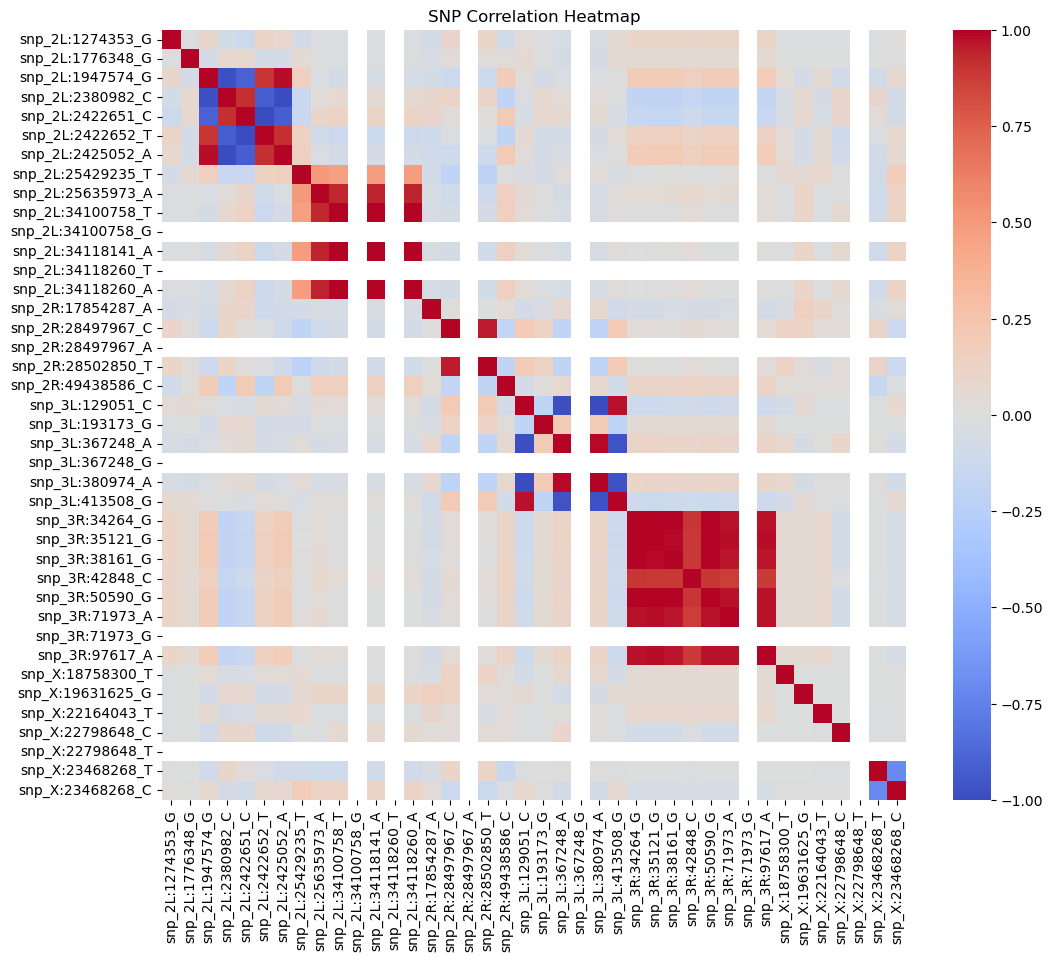

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [14]:
selected_snps = {}
for method in methods:
    selected_snps[method] = linked(df_genos[method].filter(like='snp_').dropna().astype(int), df_effs[method])

In [15]:
for method in methods:
    print(method)
    plot_snp_frequency(df_genos[method], selected_snps=selected_snps[method])

targets


KeyError: 'targets'